# Air Quality Analysis in Alaska

This notebook analyzes PM2.5 (Particulate Matter 2.5) air quality data for Alaska from 2018 to 2024.

## Table of Contents
1. [Data Loading and Preprocessing](#data-loading-and-preprocessing)
2. [Exploratory Data Analysis](#exploratory-data-analysis)
3. [Time Series Analysis](#time-series-analysis)
4. [ARIMA Modeling](#arima-modeling)
5. [Forecasting](#forecasting)

In [64]:
import warnings
warnings.filterwarnings("ignore")
import os
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Data Loading and Preprocessing

In [43]:
directory = os.listdir('C:/Users/ELSayed/Projects/AI/Air Quality/Alaska')
data = []
for file in directory:
    if file.endswith('.csv'):
        df = pd.read_csv(file)
        data.append(df)

In [44]:
data = data[::-1]

In [45]:
df = pd.concat(data)

In [46]:
df.head()

,Date,Source,Site ID,POC,Daily Mean PM2.5 Concentration,Units,Daily AQI Value,Local Site Name,Daily Obs Count,Percent Complete,...,Method Code,Method Description,CBSA Code,CBSA Name,State FIPS Code,State,County FIPS Code,County,Site Latitude,Site Longitude
0,01/02/2018,AQS,20130002,1,1.5,ug/m3 LC,8,NaN,1,100.0,...,707.0,IMPROVE Module A with Cyclone Inlet-Teflon Fil...,NaN,NaN,2,Alaska,13,Aleutians East,55.324675,-160.508331
1,01/05/2018,AQS,20130002,1,2.2,ug/m3 LC,12,NaN,1,100.0,...,707.0,IMPROVE Module A with Cyclone Inlet-Teflon Fil...,NaN,NaN,2,Alaska,13,Aleutians East,55.324675,-160.508331
2,01/08/2018,AQS,20130002,1,5.4,ug/m3 LC,30,NaN,1,100.0,...,707.0,IMPROVE Module A with Cyclone Inlet-Teflon Fil...,NaN,NaN,2,Alaska,13,Aleutians East,55.324675,-160.508331
3,01/11/2018,AQS,20130002,1,3.7,ug/m3 LC,21,NaN,1,100.0,...,707.0,IMPROVE Module A with Cyclone Inlet-Teflon Fil...,NaN,NaN,2,Alaska,13,Aleutians East,55.324675,-160.508331
4,01/14/2018,AQS,20130002,1,2.1,ug/m3 LC,12,NaN,1,100.0,...,707.0,IMPROVE Module A with Cyclone Inlet-Teflon Fil...,NaN,NaN,2,Alaska,13,Aleutians East,55.324675,-160.508331


In [47]:
df[df['Date'] == '02/01/2024']

,Date,Source,Site ID,POC,Daily Mean PM2.5 Concentration,Units,Daily AQI Value,Local Site Name,Daily Obs Count,Percent Complete,...,Method Code,Method Description,CBSA Code,CBSA Name,State FIPS Code,State,County FIPS Code,County,Site Latitude,Site Longitude
57,02/01/2024,AQS,20200018,3,11.0,ug/m3 LC,55,GARDEN/TRINITY CHRISTIAN CHURCH,1,100.0,...,170.0,Met One BAM-1020 Mass Monitor w/VSCC,11260.0,"Anchorage, AK",2,Alaska,20,Anchorage,61.205861,-149.824602
398,02/01/2024,AQS,20900035,1,27.9,ug/m3 LC,86,North Pole Fire Station #3,1,100.0,...,145.0,R & P Model 2025 PM-2.5 Sequential Air Sampler...,21820.0,"Fairbanks, AK",2,Alaska,90,Fairbanks North Star,64.762641,-147.310279
704,02/01/2024,AQS,20900040,3,21.6,ug/m3 LC,74,A Street,1,100.0,...,170.0,Met One BAM-1020 Mass Monitor w/VSCC,21820.0,"Fairbanks, AK",2,Alaska,90,Fairbanks North Star,64.845930,-147.693270
986,02/01/2024,AQS,21100004,3,3.5,ug/m3 LC,19,Floyd Dryden Middle School,1,100.0,...,238.0,Teledyne T640X at 16.67 LPM,27940.0,"Juneau, AK",2,Alaska,110,Juneau,58.388497,-134.567237
1241,02/01/2024,AQS,21700010,3,16.0,ug/m3 LC,64,NaN,1,100.0,...,170.0,Met One BAM-1020 Mass Monitor w/VSCC,11260.0,"Anchorage, AK",2,Alaska,170,Matanuska-Susitna,61.522750,-149.083639


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26336 entries, 0 to 1450
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Date                            26336 non-null  object 
 1   Source                          26336 non-null  object 
 2   Site ID                         26336 non-null  int64  
 3   POC                             26336 non-null  int64  
 4   Daily Mean PM2.5 Concentration  26336 non-null  float64
 5   Units                           26336 non-null  object 
 6   Daily AQI Value                 26336 non-null  int64  
 7   Local Site Name                 23379 non-null  object 
 8   Daily Obs Count                 26336 non-null  int64  
 9   Percent Complete                26336 non-null  float64
 10  AQS Parameter Code              26336 non-null  int64  
 11  AQS Parameter Description       26336 non-null  object 
 12  Method Code                     25930 

In [49]:
df['Date'] = pd.to_datetime(df['Date'])

In [50]:
df = df.groupby('Date')['Daily Mean PM2.5 Concentration'].mean().to_frame()

In [51]:
df.head()

,Daily Mean PM2.5 Concentration
Date,
2018-01-01,23.340000
2018-01-02,13.894118
2018-01-03,16.000000
2018-01-04,8.020000
2018-01-05,11.406667


In [52]:
df.describe()

,Daily Mean PM2.5 Concentration
count,2458.000000
mean,7.373839
std,8.693109
min,0.833333
25%,2.884586
50%,4.414379
75%,8.622321
max,116.418182


In [53]:
df.rename(columns={'Daily Mean PM2.5 Concentration': 'PM2.5'}, inplace=True)

In [54]:
df.shape

(2458, 1)

In [55]:
df.isnull().sum()

PM2.5    0
dtype: int64

## Exploratory Data Analysis

### Monthly, Yearly, and Weekly Patterns

In [56]:
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day
df['DayOfWeek'] = df.index.dayofweek

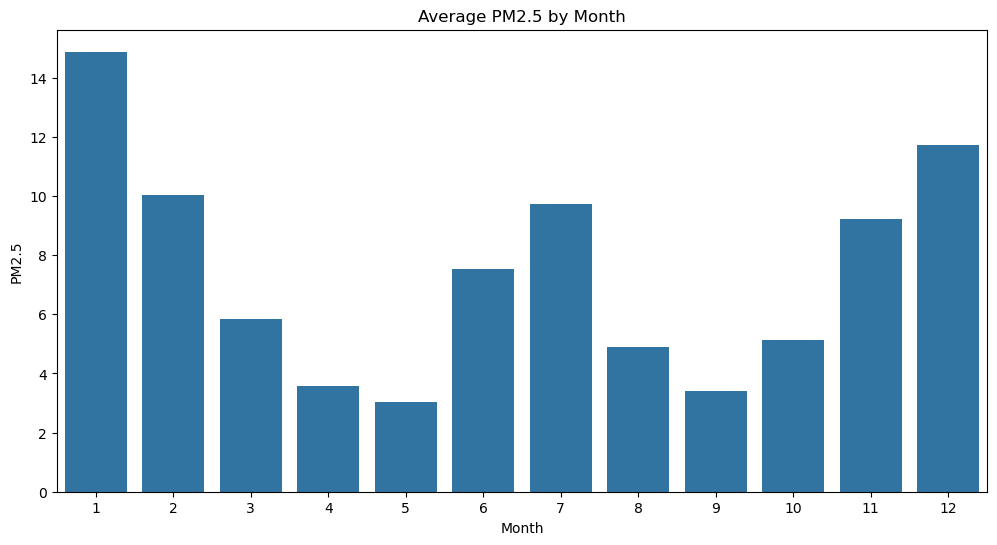

In [57]:
monthly_avg = df.groupby('Month')['PM2.5'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='Month', y='PM2.5', data=monthly_avg)
plt.title('Average PM2.5 by Month')
plt.show()

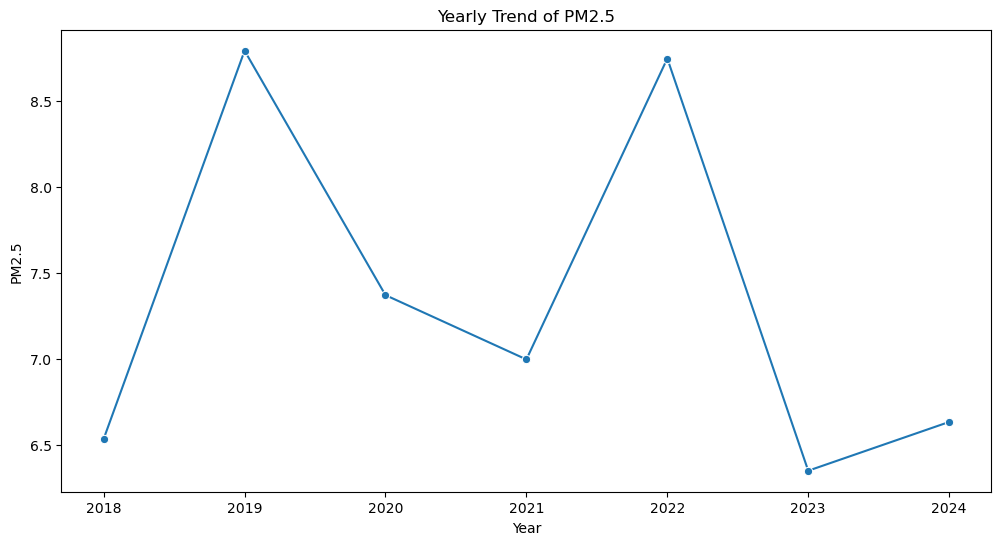

In [58]:
yearly_avg = df.groupby('Year')['PM2.5'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(x='Year', y='PM2.5', data=yearly_avg, marker='o')
plt.title('Yearly Trend of PM2.5')
plt.show()

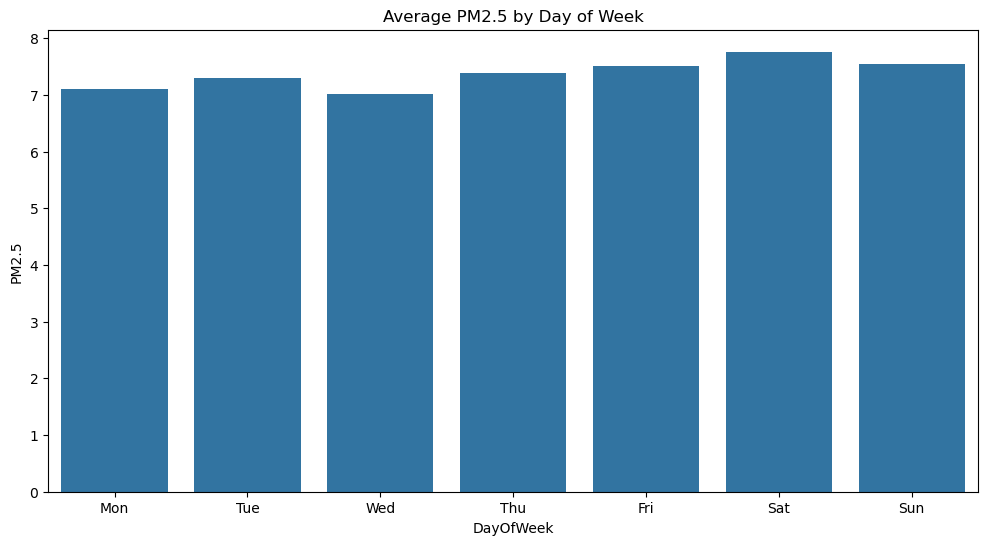

In [59]:
day_of_week_avg = df.groupby('DayOfWeek')['PM2.5'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='DayOfWeek', y='PM2.5', data=day_of_week_avg)
plt.title('Average PM2.5 by Day of Week')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

### Distribution and Box Plots

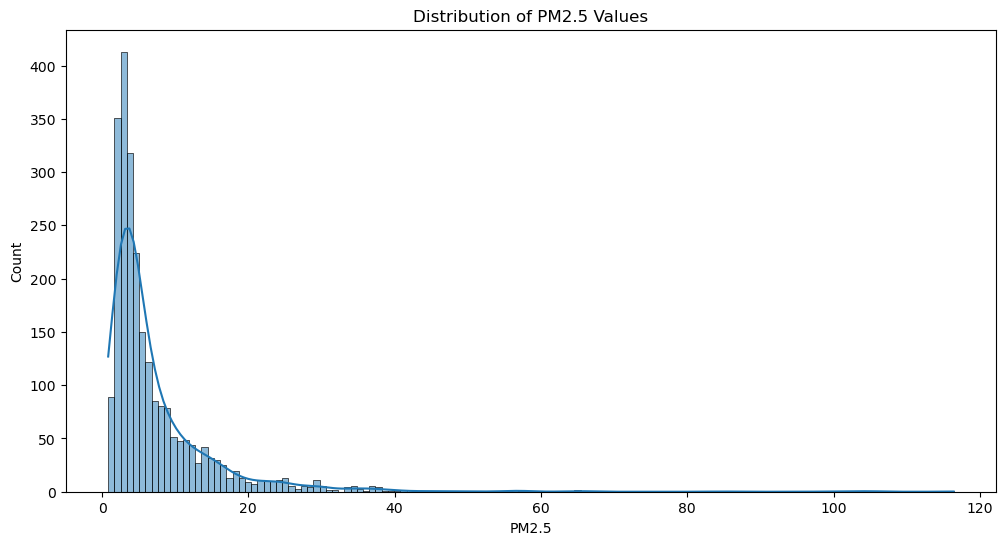

In [60]:
plt.figure(figsize=(12, 6))
sns.histplot(df['PM2.5'], kde=True)
plt.title('Distribution of PM2.5 Values')
plt.show()

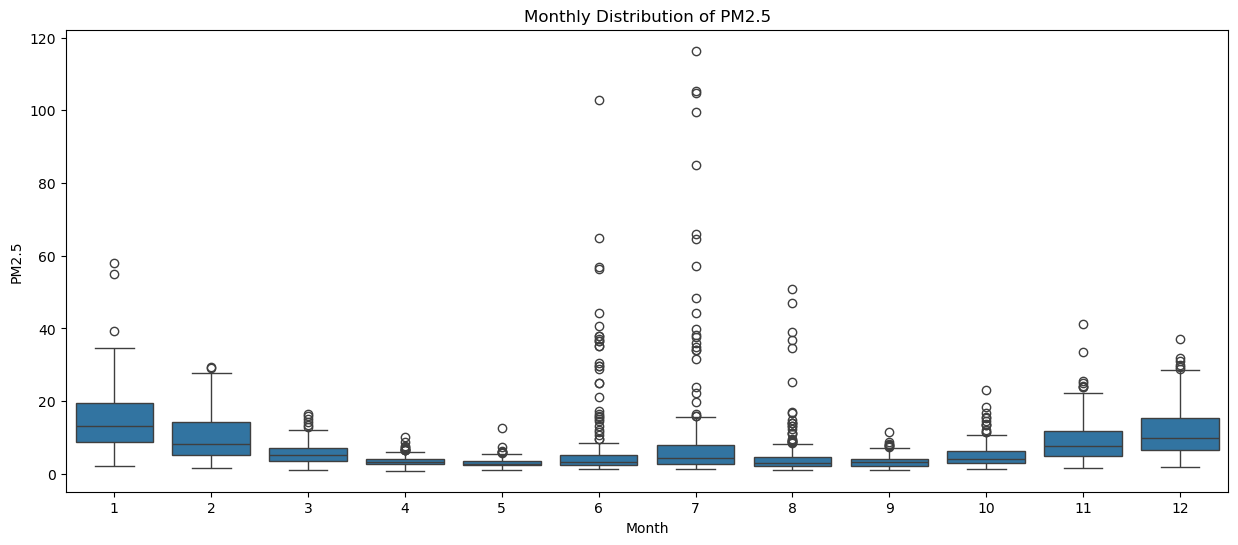

In [61]:
plt.figure(figsize=(15, 6))
sns.boxplot(x='Month', y='PM2.5', data=df)
plt.title('Monthly Distribution of PM2.5')
plt.show()

## Time Series Analysis

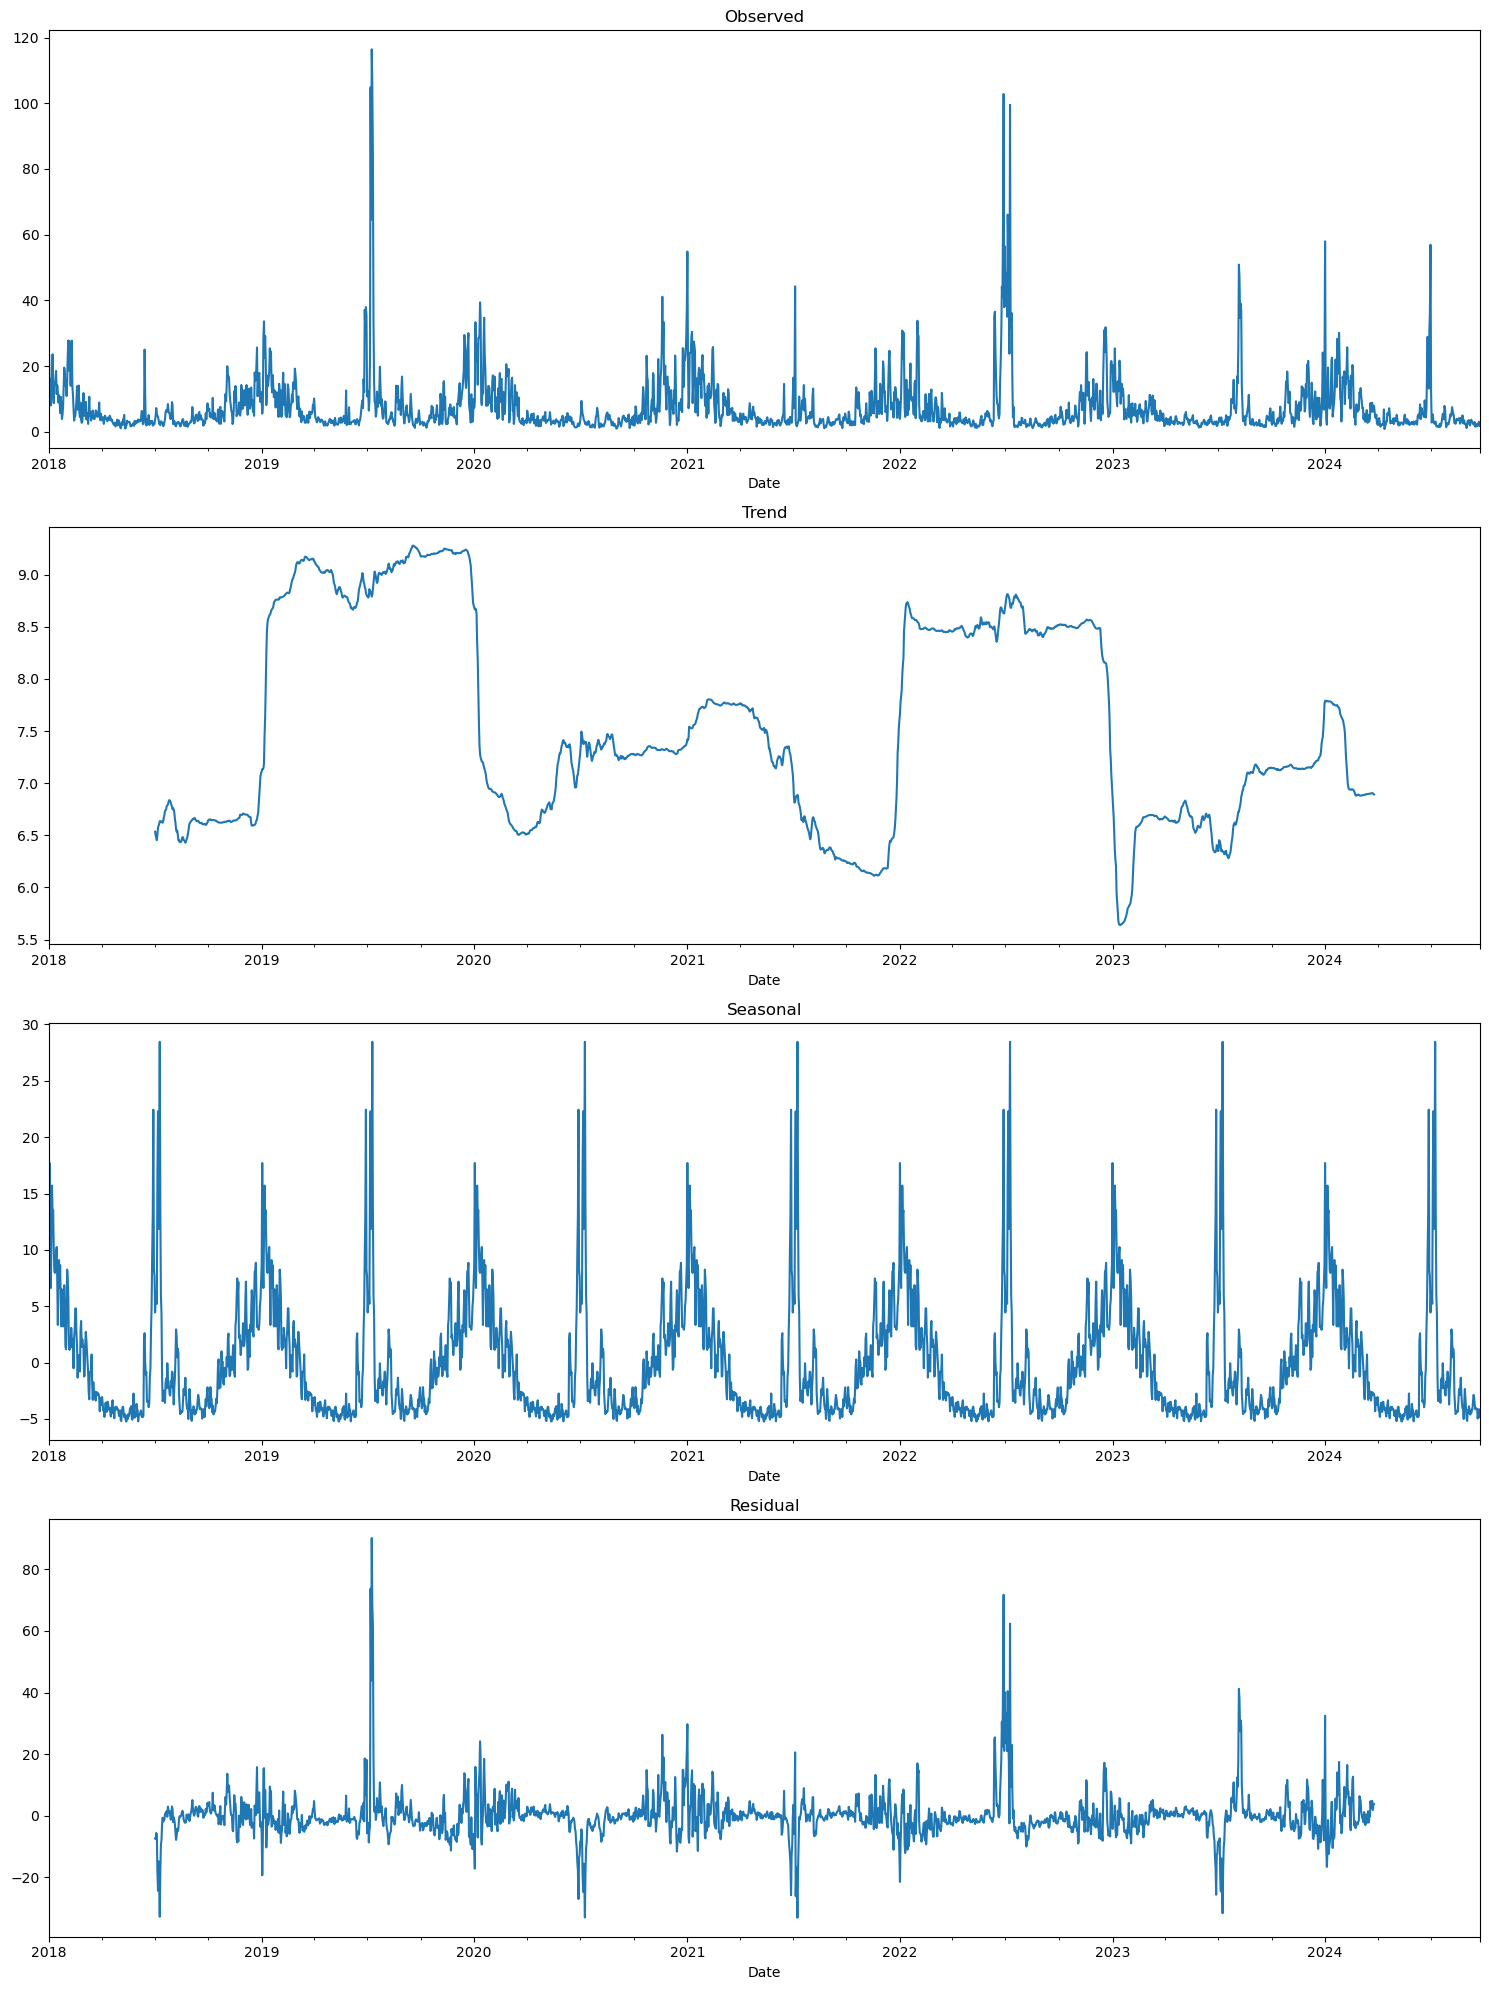

In [62]:
result = seasonal_decompose(df['PM2.5'], model='additive', period=365)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 20))
result.observed.plot(ax=ax1)
ax1.set_title('Observed')
result.trend.plot(ax=ax2)
ax2.set_title('Trend')
result.seasonal.plot(ax=ax3)
ax3.set_title('Seasonal')
result.resid.plot(ax=ax4)
ax4.set_title('Residual')
plt.tight_layout()
plt.show()

In [66]:
df = df.groupby('Date')['PM2.5'].mean().to_frame()

<Axes: xlabel='Date', ylabel='PM 2.5'>

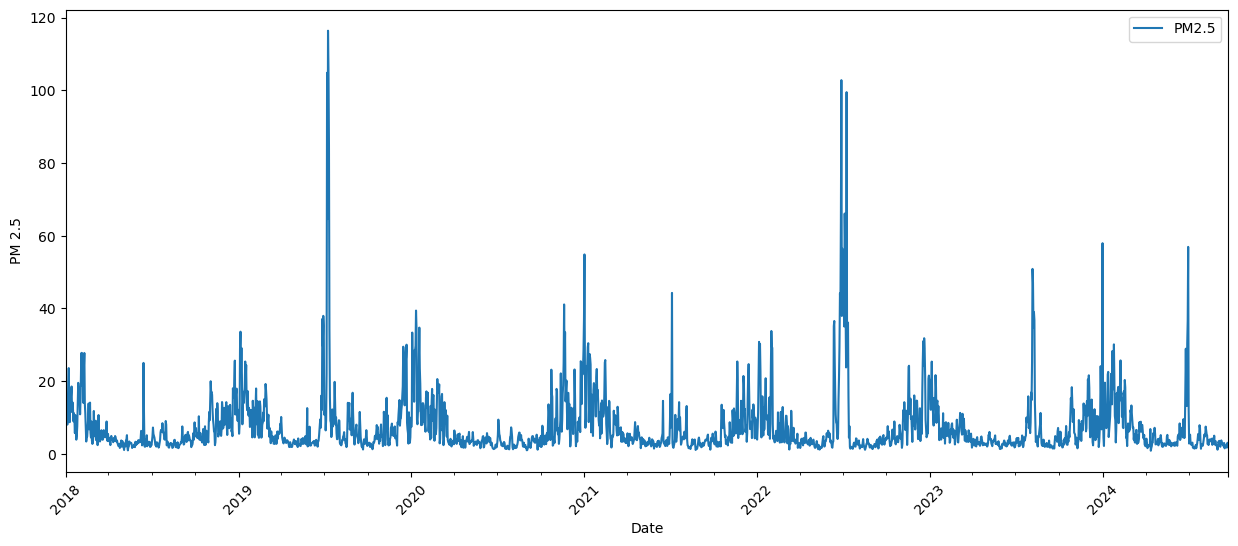

In [68]:
fig, ax = plt.subplots(figsize = (15, 6))
df.plot(xlabel='Date', ylabel='PM 2.5', ax=ax, rot=45)

<Axes: xlabel='Date', ylabel='PM 2.5'>

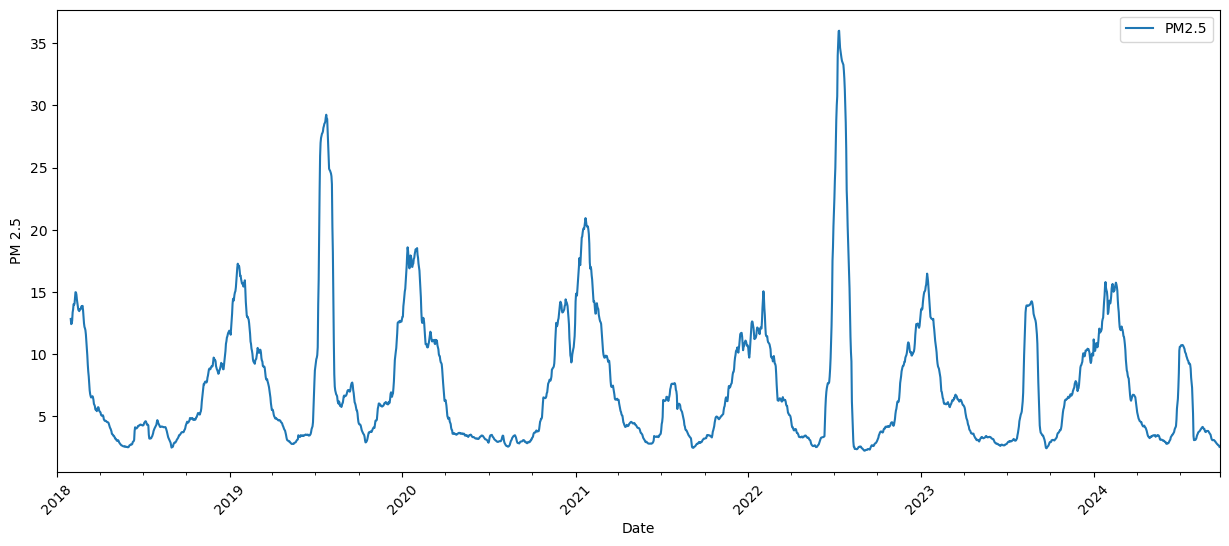

In [69]:
fig, ax = plt.subplots(figsize = (15, 6))
df.rolling(30).mean().plot(ax=ax, ylabel='PM 2.5', rot=45)

<Axes: >

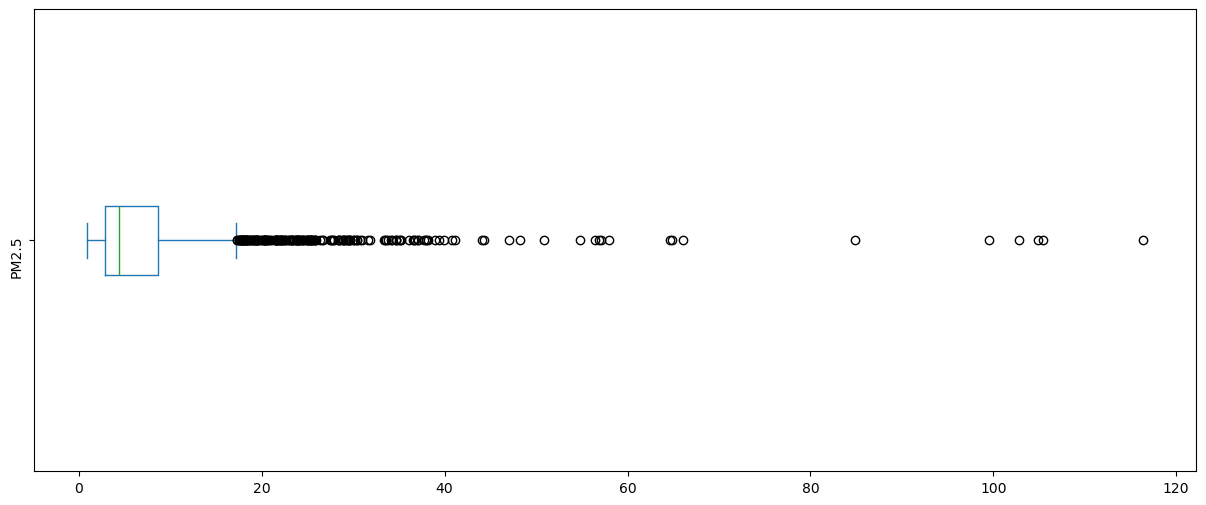

In [70]:
df.plot(figsize = (15, 6), kind='box', vert=False, rot=90)

In [71]:
Q1 = df['PM2.5'].quantile(0.25)
Q3 = df['PM2.5'].quantile(0.85)
IQR = Q3 - Q1

df['PM2.5'] = df['PM2.5'].where((df['PM2.5'] >= (Q1 - 1.5 * IQR)) & (df['PM2.5'] <= (Q3 + 1.5 * IQR)), pd.NA)

In [72]:
df.fillna(method='ffill', inplace=True)

### Autocorrelation and Partial Autocorrelation

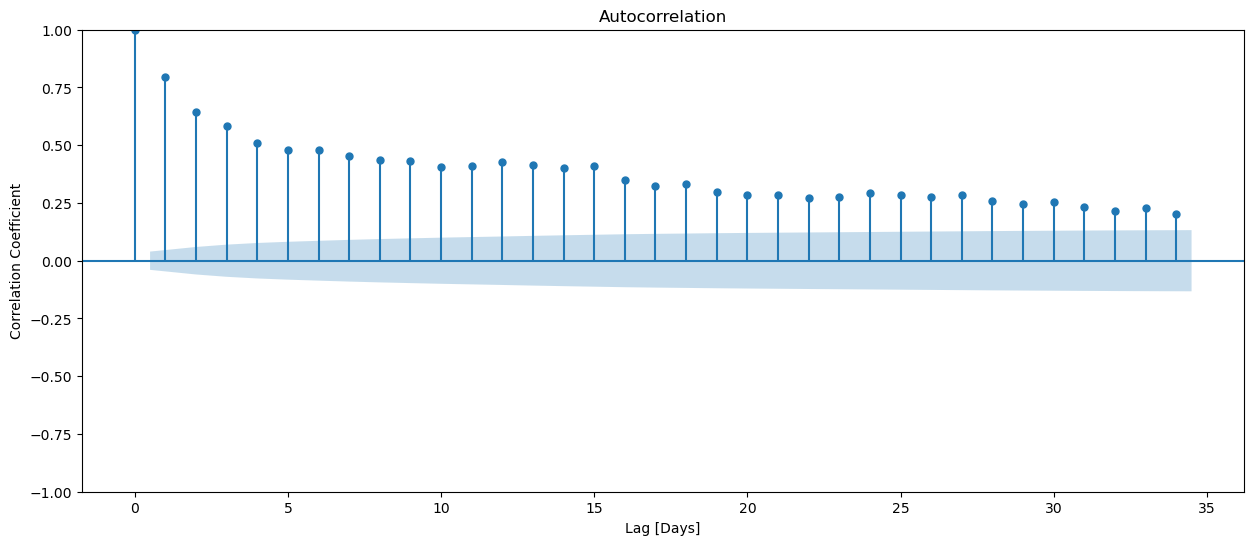

In [73]:
fig, ax = plt.subplots(figsize = (15, 6))
plot_acf(df, ax=ax);
plt.xlabel("Lag [Days]")
plt.ylabel("Correlation Coefficient");

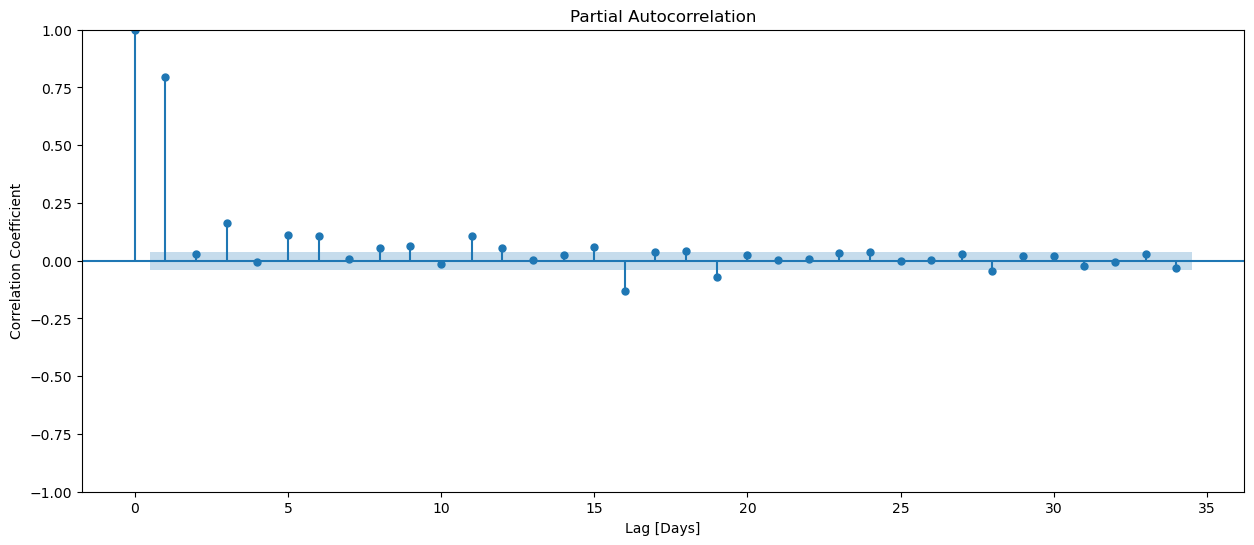

In [490]:
fig, ax = plt.subplots(figsize = (15, 6))
plot_pacf(df, ax=ax);
plt.xlabel("Lag [Days]")
plt.ylabel("Correlation Coefficient");

In [491]:
cutoff = int(len(df)*0.8)
y_train = df[:cutoff]
y_test = df[cutoff:]

In [492]:
y_train.shape

(1966, 1)

## ARIMA Modeling

In [497]:
p_params = range(0, 20, 5)
q_params = range(0, 3, 1)

In [498]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean Reading:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean Reading: PM2.5    6.84
dtype: float64
Baseline MAE: 4.31


In [499]:
mae_grid = dict()

for p in p_params:
    mae_grid[p] = list()

    for q in q_params:
        order = (p, 0, q)
        start_time = time.time()
        model = ARIMA(y_train, order=order).fit()
        elapsed_time = round(time.time() - start_time, 2)
        print(f"Trained ARIMA {order} in {elapsed_time} seconds.")
        y_pred = model.predict()
        mae = mean_absolute_error(y_train, y_pred)
        mae_grid[p].append(mae)

print()
print(mae_grid)

Trained ARIMA (0, 0, 0) in 0.24 seconds.
Trained ARIMA (0, 0, 1) in 0.25 seconds.
Trained ARIMA (0, 0, 2) in 0.35 seconds.
Trained ARIMA (5, 0, 0) in 0.91 seconds.
Trained ARIMA (5, 0, 1) in 1.23 seconds.
Trained ARIMA (5, 0, 2) in 2.84 seconds.
Trained ARIMA (10, 0, 0) in 1.87 seconds.
Trained ARIMA (10, 0, 1) in 2.03 seconds.
Trained ARIMA (10, 0, 2) in 4.43 seconds.
Trained ARIMA (15, 0, 0) in 3.78 seconds.
Trained ARIMA (15, 0, 1) in 4.7 seconds.
Trained ARIMA (15, 0, 2) in 7.71 seconds.

{0: [4.31405485765333, 3.076316084270795, 2.7795745426021927], 5: [2.217846295962097, 2.1899892533772807, 2.1825118080558386], 10: [2.184717399258214, 2.1851884677438935, 2.1850168726527865], 15: [2.172311046040149, 2.164570527382412, 2.13225709834574]}


In [500]:
mae_df = pd.DataFrame(mae_grid)
mae_df.round(4)

,0,5,10,15
0,4.3141,2.2178,2.1847,2.1723
1,3.0763,2.1900,2.1852,2.1646
2,2.7796,2.1825,2.1850,2.1323


### Walk Forward Validation

In [501]:
y_pred_wfv = pd.Series(dtype=float)
history = y_train.copy()
model = ARIMA(history, order=(5, 0, 2)).fit()

for i in range(len(y_test)):
    next_pred = model.forecast(steps=1)
    y_pred_wfv = pd.concat([y_pred_wfv, next_pred])
    
    history = pd.concat([history, y_test.iloc[[i]]])
    model = model.append(y_test.iloc[[i]])

### Model Evaluation

In [502]:
test_mae = mean_absolute_error(y_test, y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 1.94


In [503]:
y_test = y_test.squeeze()
df_predictions = pd.DataFrame(
    {'y_pred_wfv':y_pred_wfv, 'y_test':y_test}
)
fig = px.line(df_predictions, labels={'value':'P2'})
fig.show()

In [504]:
y_test.tail()

Date
2024-09-19    1.700
2024-09-20    2.325
2024-09-21    3.025
2024-09-22    2.725
2024-09-23    1.775
Name: PM2.5, dtype: float64

## Forecasting

In [505]:
model = ARIMA(df, order=(5, 0, 2)).fit()

In [506]:
# with open ('comp_model.pkl', 'wb')as f:
#     pickle.dump(model, f)

In [507]:
with open ('comp_model.pkl', 'rb')as f:
    model = pickle.load(f)

In [508]:
fut = model.forecast(steps=3)
fut.rename('PM2.5', inplace=True)

2024-09-24    2.345218
2024-09-25    2.784980
2024-09-26    2.946536
Freq: D, Name: PM2.5, dtype: float64

In [509]:
future = pd.concat([df, fut])

In [510]:
future['old_PM2.5'] = df.squeeze ()

In [511]:
future

,PM2.5,old_PM2.5
2018-01-01,23.340000,23.340000
2018-01-02,13.894118,13.894118
2018-01-03,16.000000,16.000000
2018-01-04,8.020000,8.020000
2018-01-05,11.406667,11.406667
...,...,...
2024-09-22,2.725000,2.725000
2024-09-23,1.775000,1.775000
2024-09-24,2.345218,NaN
2024-09-25,2.784980,NaN


### Visualization of Forecasts

In [512]:
fig = px.line(future.tail(100), labels={'value':'P2'})
fig.show()